In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import os

from datetime import datetime, timedelta

from scipy import signal

from tqdm import tqdm

### **Full Analysis**

In [2]:
%cd "./MCI analysis"

c:\Users\joonn\Desktop\pyscript\MCI analysis


In [3]:
from utils.data_loader import load_combined_file, convert_signal, butter_lowpass_filter
import utils.cop as Cop

from scipy.signal import find_peaks

In [4]:
#####################################
#                                   #
#         analysis settings         #
#                                   #
#####################################

sensor_columns = [
                'raw_1', 'raw_2', 'raw_3', 'raw_4', 'raw_5', 'raw_6', 'raw_7',
                'raw_8', 'raw_9', 'raw_10', 'raw_11', 'raw_12', 'raw_13','raw_14',
                'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'Timestamp' # timestamp accuracy to the second
            ]


prom = 1.5
dist = 12

In [5]:

def gait_timings(positive, negative, freq):
    pairs = {"step": [], "swing": [], "stride": []}
    timings = {"step": [], "swing": [], "stride": []}
    # print(timings)

    for n in negative:
        for p in positive:
            if n < p:
                time = abs(p - n)
                pairs["step"].append((n, p))
                timings["step"].append(time * freq)
                break

    for p in positive:
        for n in negative:
            if n > p:
                time = abs(n - p)
                pairs["swing"].append((p, n))
                timings["swing"].append(time * freq)
                break

    for i in range(len(negative) - 1):
        time = abs(negative[i] - negative[i + 1])
        pairs["stride"].append((negative[i], negative[i + 1]))
        timings["stride"].append(time * freq)

    return timings, pairs


def find_cop_velocity(data, time, peaks):
    velocity_array = []

    for i in range(len(time)):
        n, p = peaks[i]
        velocity_array.append((data[p] - data[n]) / time[i])
    return velocity_array


def calculate_gait_speed(timings, pairs, freq, acc_data=[]):
    gait_velocities = []
    print("gait Speed Data Input", len(timings), len(pairs))
    for i in range(len(pairs["stride"])):
        start_idx, end_idx = pairs["stride"][i]
        acc_window = acc_data[start_idx:end_idx]  # Extract acceleration data within the window

        time_steps = timings["stride"][i] / len(acc_window)  # Calculate time step

        # Numerical integration using trapezoidal rule
        velocity = abs(np.diff(acc_window))
        sum_velocity = np.cumsum(velocity)
        mean_velocity = np.mean(velocity)
        # integrated_velocity = np.trapz(acc_window, dx=0freq)
        integrated_velocity = np.trapz(acc_window, dx=freq)
        gait_velocities.append(integrated_velocity)

    print(len(gait_velocities))
    return gait_velocities


def get_cov(array):
    # cv =  lambda x: np.std(x) / np.mean(x)
    # var = np.apply_along_axis(cv, axis=0, arr=array)
    # idmax = np.argmax(var)
    return np.std(array) / np.mean(array)


def find_rhythm(l_timings, r_timings):
    step_time_acf = np.correlate(l_timings["step"], r_timings["step"], mode="full")  # acf - Auto Correlation Function
    stride_time_acf = np.correlate(l_timings["stride"], r_timings["stride"], mode="full")  # acf - Auto Correlation Function
    step_time_acf = step_time_acf / np.max(step_time_acf)
    stride_time_acf = stride_time_acf / np.max(stride_time_acf)
    step_time_rhythm = step_time_acf[len(step_time_acf) // 2]
    stride_time_rhythm = step_time_acf[len(step_time_acf) // 2]
    return step_time_rhythm, stride_time_rhythm


def generate_dummy(file, date, session):
    return {
        # 'File': file,
        "Session": session,
    }

def step_mask(side_pairs, chunk_length):
    mask_list = []
    steps = len(side_pairs["step"])
    
    if steps == 0:
        mask_list = [0] * chunk_length
    else:
        for i in range(steps):
            if i == 0:
                temp = [0] * side_pairs["step"][i][0]
                mask_list.extend(temp)
                temp = [1] * (side_pairs["step"][i][1] - side_pairs["step"][i][0])
                mask_list.extend(temp)
            elif i == len(side_pairs["step"]) - 1:
                temp = [0] * (side_pairs["step"][i][0] - side_pairs["step"][i - 1][1])
                mask_list.extend(temp)
                temp = [1] * (side_pairs["step"][i][1] - side_pairs["step"][i][0])
                mask_list.extend(temp)
                if len(mask_list) < chunk_length:
                    temp = [0] * (chunk_length - len(mask_list))
                    mask_list.extend(temp)
            else:
                if side_pairs["step"][i][0] > side_pairs["step"][i - 1][1] and side_pairs["step"][i][1] > side_pairs["step"][i][0]:
                    temp = [0] * (side_pairs["step"][i][0] - side_pairs["step"][i - 1][1])
                    mask_list.extend(temp)
                    temp = [1] * (side_pairs["step"][i][1] - side_pairs["step"][i][0])
                    mask_list.extend(temp)
    
    if len(mask_list) > chunk_length:
        mask_list = mask_list[:chunk_length]
    elif len(mask_list) < chunk_length:
        temp = [0] * (chunk_length - len(mask_list))
        mask_list.extend(temp)
        
    return mask_list

In [6]:
# resample data to match 20Hz frequency

def resample(df):
    ms = []
    timestamps = df['Timestamp'].unique()
    # create timestamp for each reading within a second
    for second in timestamps:
        data = df[df['Timestamp'] == second]
        instances = len(data)
        ms_interval = 1000 // instances         # 1000 milliseconds in one second
        for i in range(instances):
            strtime = str(second)
            if len(strtime) < 6:
                strtime = (6 - len(strtime)) * '0' + strtime
            instance = datetime.strptime(strtime, '%H%M%S') + timedelta(milliseconds=ms_interval*i)
            ms.append(instance)
    # resample timeseries to 50ms
    df['ms'] = ms
    df = df.set_index('ms')
    df = df.resample('50ms').ffill()
    df = df.reset_index()
    return df

In [7]:
# mask only the activity duration from the data

def activity_mask(data, threshold=7, window=60):
    diff = data.diff()
    count = []
    activity = False
    c = 0

    for x in diff:
        if x > threshold and activity == False:
            activity = True
            c = 0
        if x > threshold and activity == True:
            c = 0
            pass
        if x <= threshold and activity == True:
            if c <= window:
                pass
            else:
                activity = False
        else:
            pass

        c += 1
        count.append(activity)
    return np.array(count)

In [8]:
def start_analysis(data, session, freq=0.05):
    
    time = {}
    filt_signal = {}
    acc = {}
    mask = {}

    # Data load
    left_data = data[0]
    right_data = data[1]
    # print('----------------------------')

    # ---------------------------- Pre-processing Data --------------------------- #
    side = "left"
    time[side] = [x * freq for x in range(len(left_data))]
    filt_signal[side] = convert_signal(left_data, "pressure")
    acc[side] = convert_signal(left_data, "acc_total")

    side = "right"
    time[side] = [x * freq for x in range(len(right_data))]
    filt_signal[side] = convert_signal(right_data, "pressure")

    acc[side] = convert_signal(right_data, "acc_total")

    activity_input_left = left_data.reset_index()
    activity_input_right = right_data.reset_index()

    # ---------------------- Check if the activity is enough --------------------- #
    if len(activity_input_left) * freq / 60 < 0.1 or len(activity_input_right) * freq / 60 < 0.1:  #! Check if this works
        print("length of data", int(len(mask["left"]) * freq / 60 < 2), int(len(mask["right"]) * freq / 60 < 2), '< 2 minutes')
        return None, None

    # ------------------------------- Peak Finding ------------------------------- #
    filt_c = Cop.CenterOfPressure([activity_input_left, activity_input_right])
    # print('COP')
    cop = {}
    peaks = {}

    # -------------------------------------- Left Side ------------------------------------- #
    # print("Starting Left Data")
    side = "left"
    cop[side] = filt_c.get_cop_foot(side)
    time[side] = [x * freq for x in range(len(cop[side][0]))]

    xl = cop[side][1]
    xl = butter_lowpass_filter(xl, cutoff=2, fs=20, order=3)

    peaks[side] = {}
    peaks[side]["positive"], _ = find_peaks(xl, prominence=prom, distance=dist)
    peaks[side]["negative"], _ = find_peaks(-xl, prominence=prom, distance=dist)

    l_timings, l_pairs = gait_timings(peaks[side]["positive"], peaks[side]["negative"], freq)
    l_velocity = find_cop_velocity(xl, l_timings["step"], l_pairs["step"])

    # print('Left Data Compiled')
    # Create dictionaries for left and right sides
    cadence = len(peaks[side]["positive"]) / (len(activity_input_left) * freq / 60) * 2  # ? *2 for both feet
    left_data = {
        # 'File': file_left,
        "session": session,
        "activity_time": len(activity_input_left) * freq / 60,
        "step_time": np.mean(l_timings["step"]),
        "swing_time": np.mean(l_timings["swing"]),
        "stride_time": np.mean(l_timings["stride"]),
        "total_steps": len(peaks[side]["positive"]) * 2,
        "cadence": cadence,
        "step_variability": np.std(l_timings["step"]),
        "stride_variability": np.std(l_timings["stride"]),
        "cop_speed": np.median(l_velocity) * 2 / 100,
        # "Avg_COP_Speed": np.mean(l_velocity) / 100,
    }

    # ------------------------------------- Right Side ------------------------------------- #
    # print('Starting Right Data')
    side = "right"
    cop[side] = filt_c.get_cop_foot(side)
    time[side] = [x * freq for x in range(len(cop[side][0]))]

    xr = cop[side][1]
    xr = butter_lowpass_filter(xr, cutoff=2, fs=20, order=3)
    peaks[side] = {}
    peaks[side]["positive"], _ = find_peaks(xr, prominence=prom, distance=dist)
    peaks[side]["negative"], _ = find_peaks(-xr, prominence=prom, distance=dist)

    # fig, axs = plt.subplots(2, 1, figsize=(10, 7))

    # # First subplot
    # axs[0].plot(filt_signal[side].values, label='filtered pressure')  # Adjust x and y accordingly
    # # add the peaks (positive and negative)
    # axs[0].set_xlabel('Time')
    # axs[0].set_ylabel('Pressure')
    # axs[0].grid(True)
    # axs[0].set_title('Pressure Graph')
    # axs[0].legend(loc='upper right')

    # axs[1].plot(cop['left'][1], label='COP')  # Adjust x and y accordingly
    # axs[1].plot(xl, label='filter COP')  # Adjust x and y accordingly
    # # add the peaks (positive and negative)
    # axs[1].plot(peaks['left']["positive"], xl[peaks['left']["positive"]], "o", linewidth=3, label='toe lift')
    # axs[1].plot(peaks['left']["negative"], xl[peaks['left']["negative"]], "o", linewidth=3, label='heel strike')
    # axs[1].set_xlabel('Time')
    # axs[1].set_ylabel('COP position [mm]')
    # axs[1].grid(True)
    # axs[1].set_title('COP Graph')
    # axs[1].legend(loc='upper right')

    # # Second subplot
    # axs[1].plot(cop[side][1], label='COP')  # Adjust x and y accordingly
    # axs[1].plot(xr, label='filter COP')  # Adjust x and y accordingly
    # # add the peaks (positive and negative)
    # axs[1].plot(peaks[side]["positive"], xr[peaks[side]["positive"]], "o", linewidth=3, label='toe lift')
    # axs[1].plot(peaks[side]["negative"], xr[peaks[side]["negative"]], "o", linewidth=3, label='heel strike')
    # axs[1].set_xlabel('Time')
    # axs[1].set_ylabel('COP position [mm]')
    # axs[1].grid(True)
    # axs[1].set_title('COP Graph')
    # axs[1].legend(loc='upper right')

    # plt.tight_layout()
    # plt.show()

    r_timings, r_pairs = gait_timings(peaks[side]["positive"], peaks[side]["negative"], freq)
    r_velocity = find_cop_velocity(xr, r_timings["step"], r_pairs["step"])

    # print('Right Data Compiled')
    cadence = len(peaks[side]["positive"]) / (len(activity_input_right) * freq / 60) * 2  # ? *2 for both feet
    right_data = {
        # 'File': file_right,
        "session": session,
        "activity_time": len(activity_input_right) * freq / 60,
        "step_time": np.mean(r_timings["step"]),
        "swing_time": np.mean(r_timings["swing"]),
        "stride_time": np.mean(r_timings["stride"]),
        "total_steps": len(peaks[side]["positive"]) * 2,
        "cadence": cadence,
        "step_variability": np.std(r_timings["step"]),
        "stride_variability": np.std(r_timings["stride"]),
        "cop_speed": np.median(r_velocity) * 2 / 100,
        # "Avg_COP_Speed": np.mean(r_velocity) / 100,
    }

    # -------------------------------------- Both Sides ------------------------------------- #
    # print("Support from Left and Right")
    if len(data[0]) == len(data[1]):
        chunk_length = len(data[0])
        # print("Chunk Duration: " + str(chunk_length * freq))
    else:
        print("WARNING: Uneven Lengths")

    # print(chunk_length)
    # print("left :", len(l_pairs["step"]), l_pairs["step"])
    # print("right :", len(r_pairs["step"]), r_pairs["step"])	

    # Left Step Mask
    lsm = step_mask(l_pairs, chunk_length)
    
    # Right Step Mask
    rsm = step_mask(r_pairs, chunk_length)

    if len(lsm) == len(rsm):
        lss, rss = [], []
        for i in range(len(lsm)):
            if lsm[i] == 1 and rsm[i] == 0:
                lss.append(1)
                rss.append(0)
            elif lsm[i] == 0 and rsm[i] == 1:
                lss.append(0)
                rss.append(1)
            else:
                lss.append(0)
                rss.append(0)
    else:
        print(len(lsm), len(rsm), left_data['session'], right_data['session'])

    left_data["single_support"] = np.sum(lss) / len(l_pairs["step"]) * freq
    right_data["single_support"] = np.sum(rss) / len(r_pairs["step"]) * freq
    
    if len(lsm) == len(rsm):
        double_support = []
        for i in range(len(lsm)):
            if lsm[i] == 1 and rsm[i] == 1:
                double_support.append(1)
            else:
                double_support.append(0)
        left_data["double_support"] = np.sum(double_support) / len(l_pairs["step"]) * freq
        right_data["double_support"] = np.sum(double_support) / len(r_pairs["step"]) * freq

    # print(left_data)
    # print(right_data)

    return left_data, right_data

In [10]:
path, patient_id, date, session_id,file_left, file_right = [], [], [], [], [], []
subjects = 'mci015'

for root, dirs, files in os.walk('C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data'):
    if subjects not in root:
        continue
    
    print(root)
    for file in files:
        if 'htx' in dirs or 'compiled' in dirs or 'analysis' in dirs:
            continue

        
        if 'Left' in file:
            path.append(root)
            patient_id.append(root.split('/')[-1].split('\\')[1])
            date.append(root.split('/')[-1].split('\\')[2])
            session_id.append(file.split('_')[0])
            file_left.append(file)
        elif 'Right' in file:
            file_right.append(file)
        else:
            pass

# sanity check
if len(path) == len(patient_id) == len(date) == len(session_id) == len(file_left) == len(file_right):
    print('--- sanity check passed ---')
    dataset = pd.DataFrame({'path': path, 'patient_id': patient_id, 'date': date, 'session_id': session_id, 'file_left': file_left, 'file_right': file_right})
    print(len(dataset))
else:
    print('--- sanity check failed ---')
    print(len(path), len(patient_id), len(date), len(session_id), len(file_left), len(file_right))

C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015
C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015\2024-03-08
C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015\2024-03-12
C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015\2024-03-13
C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015\2024-03-15
C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015\2024-03-18
C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015\2024-03-27
C:/Users/joonn/Desktop/pyscript/MCI analysis/data/mci_raw_data\mci015\2024-03-31
--- sanity check passed ---
19


In [12]:
dataset

,path,patient_id,date,session_id,file_left,file_right
0,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-08,S272,S272_20240308_rawDataLeft_4XYXFKBcZm.txt,S272_20240308_rawDataRight_4XYXFKBcZm.txt
1,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-08,S273,S273_20240308_rawDataLeft_4XYXFKBcZm.txt,S273_20240308_rawDataRight_4XYXFKBcZm.txt
2,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-08,S274,S274_20240308_rawDataLeft_4XYXFKBcZm.txt,S274_20240308_rawDataRight_4XYXFKBcZm.txt
3,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-08,S275,S275_20240308_rawDataLeft_4XYXFKBcZm.txt,S275_20240308_rawDataRight_4XYXFKBcZm.txt
4,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-08,S276,S276_20240308_rawDataLeft_4XYXFKBcZm.txt,S276_20240308_rawDataRight_4XYXFKBcZm.txt
5,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-08,S280,S280_20240308_rawDataLeft_4XYXFKBcZm.txt,S280_20240308_rawDataRight_4XYXFKBcZm.txt
6,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-12,S425,S425_20240312_rawDataLeft_NDEwLxlxpB.txt,S425_20240312_rawDataRight_NDEwLxlxpB.txt
7,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-13,S426,S426_20240313_rawDataLeft_NDEwLxlxpB.txt,S426_20240313_rawDataRight_NDEwLxlxpB.txt
8,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-13,S427,S427_20240313_rawDataLeft_NDEwLxlxpB.txt,S427_20240313_rawDataRight_NDEwLxlxpB.txt
9,C:/Users/joonn/Desktop/pyscript/MCI analysis/d...,mci015,2024-03-13,S428,S428_20240313_rawDataLeft_NDEwLxlxpB.txt,S428_20240313_rawDataRight_NDEwLxlxpB.txt


In [13]:
left_final = []
right_final = []

progress_bar = tqdm(total=len(dataset))
### WARNING: it may take some time to run this cell ###

for i in range(len(dataset)):

    testset = dataset.iloc[i]                                                                                                                   # dataset to evaluate
    left = pd.read_csv(os.path.join(testset['path'], testset['file_left']), names=sensor_columns)                                               # left raw data file
    right = pd.read_csv(os.path.join(testset['path'], testset['file_right']), names=sensor_columns)                                             # right raw data file
    left, right = resample(left), resample(right)                                                                                               # resample data to match 20Hz frequency
    df = pd.merge(left.drop('Timestamp', axis=1), right.drop('Timestamp', axis=1), on='ms', how='inner', suffixes=('_left', '_right'))          # merge left and right raw data
    # df = butter_filter(df)                                                                                                                      # butter filter data

    acc_left = np.sqrt((df['acc_x_left']*9.81/4096)**2 + (df['acc_y_left']*9.81/4096)**2 + (df['acc_z_left']*9.81/4096)**2) - 9.81
    acc_right = np.sqrt((df['acc_x_right']*9.81/4096)**2 + (df['acc_y_right']*9.81/4096)**2 + (df['acc_z_right']*9.81/4096)**2) - 9.81
    df = df[activity_mask(acc_left) | activity_mask(acc_right)]                                                                                 # mask only the activity duration from the data

    if len(df) <= 200:                                                                                                                          # remove short data
        left_final.append(None)
        right_final.append(None)
    else:
        left_data, right_data = load_combined_file(df, filter=True, frequency=20, cutoff=2, order=4)
        session_number = dataset['session_id'][i].replace('S,', '')

        left_item, right_item = start_analysis([left_data, right_data], session_number)

        left_final.append(left_item)
        right_final.append(right_item)
    
    progress_bar.update(1)                                                                                                    

progress_bar.close()

  0%|          | 0/19 [00:00<?, ?it/s]

 21%|██        | 4/19 [00:00<00:01,  7.94it/s]

41 columns found
Filtering data
41 columns found
Filtering data


 32%|███▏      | 6/19 [00:00<00:02,  5.42it/s]

41 columns found
Filtering data


 37%|███▋      | 7/19 [00:01<00:02,  4.01it/s]

41 columns found
Filtering data


 42%|████▏     | 8/19 [00:06<00:16,  1.54s/it]

41 columns found
Filtering data


 47%|████▋     | 9/19 [00:10<00:24,  2.47s/it]

41 columns found
Filtering data


 53%|█████▎    | 10/19 [00:15<00:28,  3.13s/it]

41 columns found
Filtering data


 58%|█████▊    | 11/19 [00:20<00:28,  3.58s/it]

41 columns found
Filtering data


 63%|██████▎   | 12/19 [00:24<00:27,  3.90s/it]

41 columns found
Filtering data


 68%|██████▊   | 13/19 [00:29<00:24,  4.11s/it]

41 columns found
Filtering data


 74%|███████▎  | 14/19 [00:34<00:21,  4.29s/it]

41 columns found
Filtering data


 79%|███████▉  | 15/19 [00:37<00:16,  4.00s/it]

41 columns found
Filtering data


 84%|████████▍ | 16/19 [00:39<00:09,  3.24s/it]

41 columns found
Filtering data
41 columns found
Filtering data


100%|██████████| 19/19 [00:44<00:00,  2.32s/it]


In [14]:
x = dataset
x_left = left_final
x_right = right_final

In [18]:
# save left and right data

left_df = pd.DataFrame(left_final)
right_df = pd.DataFrame(right_final)
left_df.to_csv('C:/Users/joonn/Desktop/pyscript/MCI analysis/data/compiled_data/final_left_df.csv')
right_df.to_csv('C:/Users/joonn/Desktop/pyscript/MCI analysis/data/compiled_data/final_right_df.csv')

In [15]:
# # For testing only

# left_data, right_data = load_combined_file(df, filter=True, frequency=20, cutoff=2, order=4)
# session_number = dataset['session_id'][374].replace('S,', '')

# left_item, right_item = start_analysis([left_data, right_data], session_number)

In [ ]:
# merge dataset with 

In [16]:
session = []
activity_time = []
step_time_left = []
step_time_right = []
swing_time_left = []
swing_time_right = []
stride_time_left = []
stride_time_right = []
total_steps = []
cadence = []
step_variability_left = []
step_variability_right = []
stride_variability_left = []
stride_variability_right = []
cop_speed_left = []
cop_speed_right = []
single_support_left = []
single_support_right = []
double_support = []

if len(x_left) == len(x_right):
    print(len(left_final))
    for i in range(len(left_final)):
        if left_final[i] is not None:
            session.append(left_final[i]['session'])
            activity_time.append(left_final[i]['activity_time'])
            step_time_left.append(left_final[i]['step_time'])
            swing_time_left.append(left_final[i]['swing_time'])
            stride_time_left.append(left_final[i]['stride_time'])
            total_steps.append(left_final[i]['total_steps'] + right_final[i]['total_steps'] / 2)
            cadence.append((left_final[i]['cadence'] + right_final[i]['cadence']) / 2)
            step_variability_left.append(left_final[i]['step_variability'])
            stride_variability_left.append(left_final[i]['stride_variability'])
            cop_speed_left.append(left_final[i]['cop_speed'])
            single_support_left.append(left_final[i]['single_support'])
            double_support.append((left_final[i]['double_support'] + right_final[i]['double_support']) / 2)

        if right_final[i] is not None:
            step_time_right.append(right_final[i]['step_time'])
            swing_time_right.append(right_final[i]['swing_time'])
            stride_time_right.append(right_final[i]['stride_time'])
            step_variability_right.append(right_final[i]['step_variability'])
            stride_variability_right.append(right_final[i]['stride_variability'])
            cop_speed_right.append(right_final[i]['cop_speed'])
            single_support_right.append(right_final[i]['single_support'])

        if left_final[i] is None or right_final[i] is None:
            session.append(0)
            activity_time.append(0)
            step_time_left.append(0)
            swing_time_left.append(0)
            stride_time_left.append(0)
            total_steps.append(0)
            cadence.append(0)
            step_variability_left.append(0)
            stride_variability_left.append(0)
            cop_speed_left.append(0)
            single_support_left.append(0)
            double_support.append(0)

            step_time_right.append(0)
            swing_time_right.append(0)
            stride_time_right.append(0)
            step_variability_right.append(0)
            stride_variability_right.append(0)
            cop_speed_right.append(0)
            single_support_right.append(0)

19


### **Base Analysis**

In [5]:
# x = pd.read_csv('dataset_full_extra.csv')
fd = x

In [17]:
if len(x) == len(x_left) == len(x_right):
    x['session'] = session
    x['activity_time'] = activity_time
    x['step_time_left'] = step_time_left
    x['step_time_right'] = step_time_right
    x['swing_time_left'] = swing_time_left
    x['swing_time_right'] = swing_time_right
    x['stride_time_left'] = stride_time_left
    x['stride_time_right'] = stride_time_right
    x['total_steps'] = total_steps
    x['cadence'] = cadence
    x['step_variability_left'] = step_variability_left
    x['step_variability_right'] = step_variability_right
    x['stride_variability_left'] = stride_variability_left
    x['stride_variability_right'] = stride_variability_right
    x['cop_speed_left'] = cop_speed_left
    x['cop_speed_right'] = cop_speed_right
    x['single_support_left'] = single_support_left
    x['single_support_right'] = single_support_right
    x['double_support'] = double_support    

    x.to_csv('dataset_full_extra_mci015.csv', index=False)
else:
    print(len(fd), len(left_final), len(right_final))

In [6]:
fd.fillna(0, inplace=True)
fd = fd[fd['speed'] > 0]
# fd

KeyError: 'speed'

In [68]:
from scipy.stats import ttest_ind, describe, norm

def ttest(data):
    params = data.columns
    output = {}
    for param in params:
        try:
            data[param].astype(float)

            t_stat, p_val = ttest_ind(data[data['group'] == 'MCI'][param].astype(float), data[data['group'] == 'NORMAL'][param].astype(float), equal_var=False)
            sig = p_val < 0.05
            output[param] = np.round(t_stat, 2), np.round(p_val, 2), sig
            
        except ValueError:
            output[param] = 'NA', 'NA', 'NA'

    output = pd.DataFrame.from_dict(output, orient='index', columns=['T-stat', 'P-val', 'Significant'])

    return output


In [69]:
def infer(data, params, output_df):
    temp1 = []
    if 'group' in params:
        params = params[1:]
    for param in params:
        temp2 = []
        parameter = data[['group', param]]

        mean_healthy = np.round(np.mean(parameter[data['group'] == 'NORMAL'][param]), 2)
        mean_mci = np.round(np.mean(parameter[data['group'] == 'MCI'][param]), 2)
        median_healthy = np.round(np.median(parameter[data['group'] == 'NORMAL'][param]), 2)
        median_mci = np.round(np.median(parameter[data['group'] == 'MCI'][param]), 2)
        std_healthy = np.round(np.std(parameter[data['group'] == 'NORMAL'][param]), 2)
        std_mci = np.round(np.std(parameter[data['group'] == 'MCI'][param]), 2)
        range_healthy = (np.round(np.min(parameter[data['group'] == 'NORMAL'][param]), 2), np.round(np.max(parameter[data['group'] == 'NORMAL'][param]), 2))
        range_mci = (np.round(np.min(parameter[data['group'] == 'MCI'][param]), 2), np.round(np.max(parameter[data['group'] == 'MCI'][param]), 2))

        temp2.append(mean_healthy)
        temp2.append(mean_mci)
        temp2.append(median_healthy)
        temp2.append(median_mci)
        temp2.append(std_healthy)
        temp2.append(std_mci)
        temp2.append(range_healthy)
        temp2.append(range_mci)

        temp1.append(temp2)        

    temp1 = pd.DataFrame(temp1, index=params, columns=['Mean_Healthy', 'Mean_MCI', 'Median_Healthy', 'Median_MCI', 'Std_Healthy', 'Std_MCI', 'Range_Healthy', 'Range_MCI'])

    if len(output_df) == len(temp1):
        output_df = pd.concat([output_df, temp1], axis=1)
    return output_df

#### **Aggregated Patients**

In [8]:
agg_df = fd.groupby(['group', 'patient_id'])[['date']].min()
agg_df.rename(columns={'date': 'start_date'}, inplace=True)
agg_df['end_date'] = fd.groupby(['group', 'patient_id'])['date'].max()

# agg_df['total_sessions'] = fd.groupby(['group', 'patient_id']).count()['session_id']
# agg_df['active_sessions'] = fd[fd['speed'] > 0].groupby(['group', 'patient_id']).count()['session_id']
# agg_df['pct_active_sessions'] = np.round(agg_df['active_sessions'] / agg_df['total_sessions'] * 100, 2)

agg_df['avg_speed'] = np.round(fd[fd['speed'] > 0].groupby(['group', 'patient_id'])['speed'].mean(), 2)
agg_df['std_speed'] = np.round(fd[fd['speed'] > 0].groupby(['group', 'patient_id'])['speed'].std(), 2)

agg_df['total_duration'] = np.round(fd.groupby(['group', 'patient_id'])['full_duration'].sum() / 3600, 2)
agg_df['active_duration'] = np.round(fd[fd['speed'] > 0].groupby(['group', 'patient_id'])['full_duration'].sum() / 3600, 2)
agg_df['pct_active_duration'] = np.round(agg_df['active_duration'] / agg_df['total_duration'] * 100, 2)

agg_df['pct_sitting'] = np.round(fd.groupby(['group', 'patient_id'])['sit_duration'].sum() / 3600 / agg_df['total_duration'] * 100, 2)
agg_df['pct_standing'] = np.round(fd.groupby(['group', 'patient_id'])['stand_duration'].sum() / 3600 / agg_df['total_duration'] * 100, 2)
agg_df['pct_walking'] = np.round(fd.groupby(['group', 'patient_id'])['walk_duration'].sum() / 3600 / agg_df['total_duration'] * 100, 2)
agg_df['pct_running'] = np.round(fd.groupby(['group', 'patient_id'])['run_duration'].sum() / 3600 / agg_df['total_duration'] * 100, 2)

agg_df['avg_steptl'] = np.round(fd.groupby(['group', 'patient_id'])['step_time_left'].mean(), 2)
agg_df['std_steptl'] = np.round(fd.groupby(['group', 'patient_id'])['step_time_left'].std(), 2)
agg_df['avg_steptr'] = np.round(fd.groupby(['group', 'patient_id'])['step_time_right'].mean(), 2)
agg_df['std_steptr'] = np.round(fd.groupby(['group', 'patient_id'])['step_time_right'].std(), 2)

agg_df['avg_swingtl'] = np.round(fd.groupby(['group', 'patient_id'])['swing_time_left'].mean(), 2)
agg_df['std_swingtl'] = np.round(fd.groupby(['group', 'patient_id'])['swing_time_left'].std(), 2)
agg_df['avg_swingtr'] = np.round(fd.groupby(['group', 'patient_id'])['swing_time_right'].mean(), 2)
agg_df['std_swingtr'] = np.round(fd.groupby(['group', 'patient_id'])['swing_time_right'].std(), 2)

agg_df['avg_stridetl'] = np.round(fd.groupby(['group', 'patient_id'])['stride_time_left'].mean(), 2)
agg_df['std_stridetl'] = np.round(fd.groupby(['group', 'patient_id'])['stride_time_left'].std(), 2)
agg_df['avg_stridetr'] = np.round(fd.groupby(['group', 'patient_id'])['stride_time_right'].mean(), 2)
agg_df['std_stridetr'] = np.round(fd.groupby(['group', 'patient_id'])['stride_time_right'].std(), 2)

agg_df['avg_cadence'] = np.round(fd.groupby(['group', 'patient_id'])['cadence'].mean(), 2)
agg_df['std_cadence'] = np.round(fd.groupby(['group', 'patient_id'])['cadence'].std(), 2)

agg_df['avg_copl'] = np.round(fd.groupby(['group', 'patient_id'])['cop_speed_left'].mean(), 2)
agg_df['std_copl'] = np.round(fd.groupby(['group', 'patient_id'])['cop_speed_left'].std(), 2)
agg_df['avg_copr'] = np.round(fd.groupby(['group', 'patient_id'])['cop_speed_right'].mean(), 2)
agg_df['std_copr'] = np.round(fd.groupby(['group', 'patient_id'])['cop_speed_right'].std(), 2)

agg_df['avg_ssl'] = np.round(fd.groupby(['group', 'patient_id'])['single_support_left'].mean(), 2)
agg_df['std_ssl'] = np.round(fd.groupby(['group', 'patient_id'])['single_support_left'].std(), 2)
agg_df['avg_ssr'] = np.round(fd.groupby(['group', 'patient_id'])['single_support_right'].mean(), 2)
agg_df['std_ssr'] = np.round(fd.groupby(['group', 'patient_id'])['single_support_right'].std(), 2)

agg_df['avg_ds'] = np.round(fd.groupby(['group', 'patient_id'])['double_support'].mean(), 2)
agg_df['std_ds'] = np.round(fd.groupby(['group', 'patient_id'])['double_support'].std(), 2)


agg_df.reset_index(inplace=True)
agg_df

,group,patient_id,start_date,end_date,avg_speed,std_speed,total_duration,active_duration,pct_active_duration,pct_sitting,...,avg_copl,std_copl,avg_copr,std_copr,avg_ssl,std_ssl,avg_ssr,std_ssr,avg_ds,std_ds
0,MCI,mci001,15/1/24,6/2/24,0.94,0.05,59.14,59.14,100.0,49.62,...,0.80,0.41,0.97,0.42,0.40,0.49,0.32,0.16,0.44,0.43
1,MCI,mci012,15/1/24,5/2/24,0.97,0.04,75.60,75.60,100.0,20.22,...,0.27,0.38,0.53,0.39,0.60,0.36,0.28,0.07,0.62,0.39
2,MCI,mci013,6/3/24,9/3/24,0.88,0.10,2.87,2.87,100.0,48.36,...,0.90,0.52,1.05,0.72,0.39,0.35,0.25,0.04,0.54,0.61
3,MCI,mci014,1/3/24,9/3/24,0.94,0.09,222.37,222.37,100.0,44.85,...,0.23,0.32,0.11,0.21,1.18,1.03,3.96,5.65,0.84,0.77
4,MCI,mci016,18/3/24,24/3/24,0.92,0.14,6.73,6.73,100.0,32.35,...,1.28,0.63,0.82,0.33,0.34,0.16,0.30,0.11,0.28,0.10
5,MCI,mci017,20/3/24,24/3/24,0.91,0.12,35.22,35.22,100.0,22.58,...,0.46,0.45,0.60,0.45,1.51,2.35,0.29,0.06,1.51,2.25
6,MCI,mci018,1/5/24,30/4/24,0.95,0.06,178.38,178.38,100.0,34.85,...,0.36,0.24,0.23,0.30,1.15,4.45,0.73,0.79,1.06,4.56
7,NORMAL,mci002,1/9/23,8/9/23,0.97,0.03,24.70,24.70,100.0,33.02,...,0.88,0.47,1.70,0.86,0.35,0.09,0.34,0.20,0.28,0.11
8,NORMAL,mci003,13/2/24,6/3/24,0.96,0.08,55.23,55.23,100.0,74.67,...,0.73,0.91,0.64,0.82,0.39,0.32,0.42,0.24,0.36,0.35
9,NORMAL,mci004,10/11/23,9/11/23,0.96,0.04,49.69,49.69,100.0,58.98,...,0.57,0.34,0.82,0.43,0.26,0.05,0.27,0.05,0.29,0.06


In [59]:
left_parameters = ['group', 'active_duration', 'avg_steptl', 'avg_swingtl', 'avg_stridetl', 'avg_cadence', 'std_stridetl', 'avg_copl', 'avg_ds']
left_plt = ['group', 'active_duration', 'avg_stridetl', 'std_stridetl', 'avg_cadence', 'avg_copl', 'avg_ds']
right_parameters = ['group', 'active_duration', 'avg_steptr', 'avg_swingtr', 'avg_stridetr', 'avg_cadence', 'std_stridetr', 'avg_copr', 'avg_ds']
right_plt = ['group', 'active_duration', 'avg_stridetr', 'std_stridetr', 'avg_cadence', 'avg_copr', 'avg_ds']

In [73]:
aggopl = agg_df[left_parameters]

aggopl = ttest(aggopl)

aggopl.drop(columns=['T-stat'], index='group', inplace=True)
# aggopl

In [74]:
aggopl = infer(agg_df, left_parameters, aggopl)
aggopl = aggopl[['Mean_Healthy', 'Mean_MCI', 'Median_Healthy', 'Median_MCI', 'Std_Healthy', 'Std_MCI', 'Range_Healthy', 'Range_MCI', 'P-val', 'Significant']]
aggopl.index = ['Total Activity', 'Step Time', 'Swing Time', 'Gait Time', 'Cadence', 'Gait Variability', 'COP Speed', 'Double Support']
aggopl

,Mean_Healthy,Mean_MCI,Median_Healthy,Median_MCI,Std_Healthy,Std_MCI,Range_Healthy,Range_MCI,P-val,Significant
Total Activity,58.58,82.90,53.65,59.14,49.84,78.98,"(8.19, 203.56)","(2.87, 222.37)",0.52,False
Step Time,1.08,1.56,0.76,1.22,0.63,0.82,"(0.58, 2.38)","(0.64, 3.03)",0.24,False
Swing Time,0.90,1.42,0.72,1.12,0.52,0.65,"(0.58, 2.49)","(0.62, 2.26)",0.13,False
Gait Time,1.80,2.58,1.38,1.77,0.99,1.42,"(1.11, 4.65)","(1.42, 5.44)",0.26,False
Cadence,84.13,70.93,87.67,79.74,17.45,18.06,"(48.35, 106.29)","(41.55, 91.19)",0.18,False
Gait Variability,1.54,3.24,0.73,2.35,2.24,2.63,"(0.12, 8.36)","(0.89, 8.76)",0.21,False
COP Speed,0.70,0.61,0.70,0.46,0.18,0.36,"(0.47, 1.01)","(0.23, 1.28)",0.62,False
Double Support,0.45,0.76,0.38,0.62,0.25,0.39,"(0.27, 1.09)","(0.28, 1.51)",0.12,False


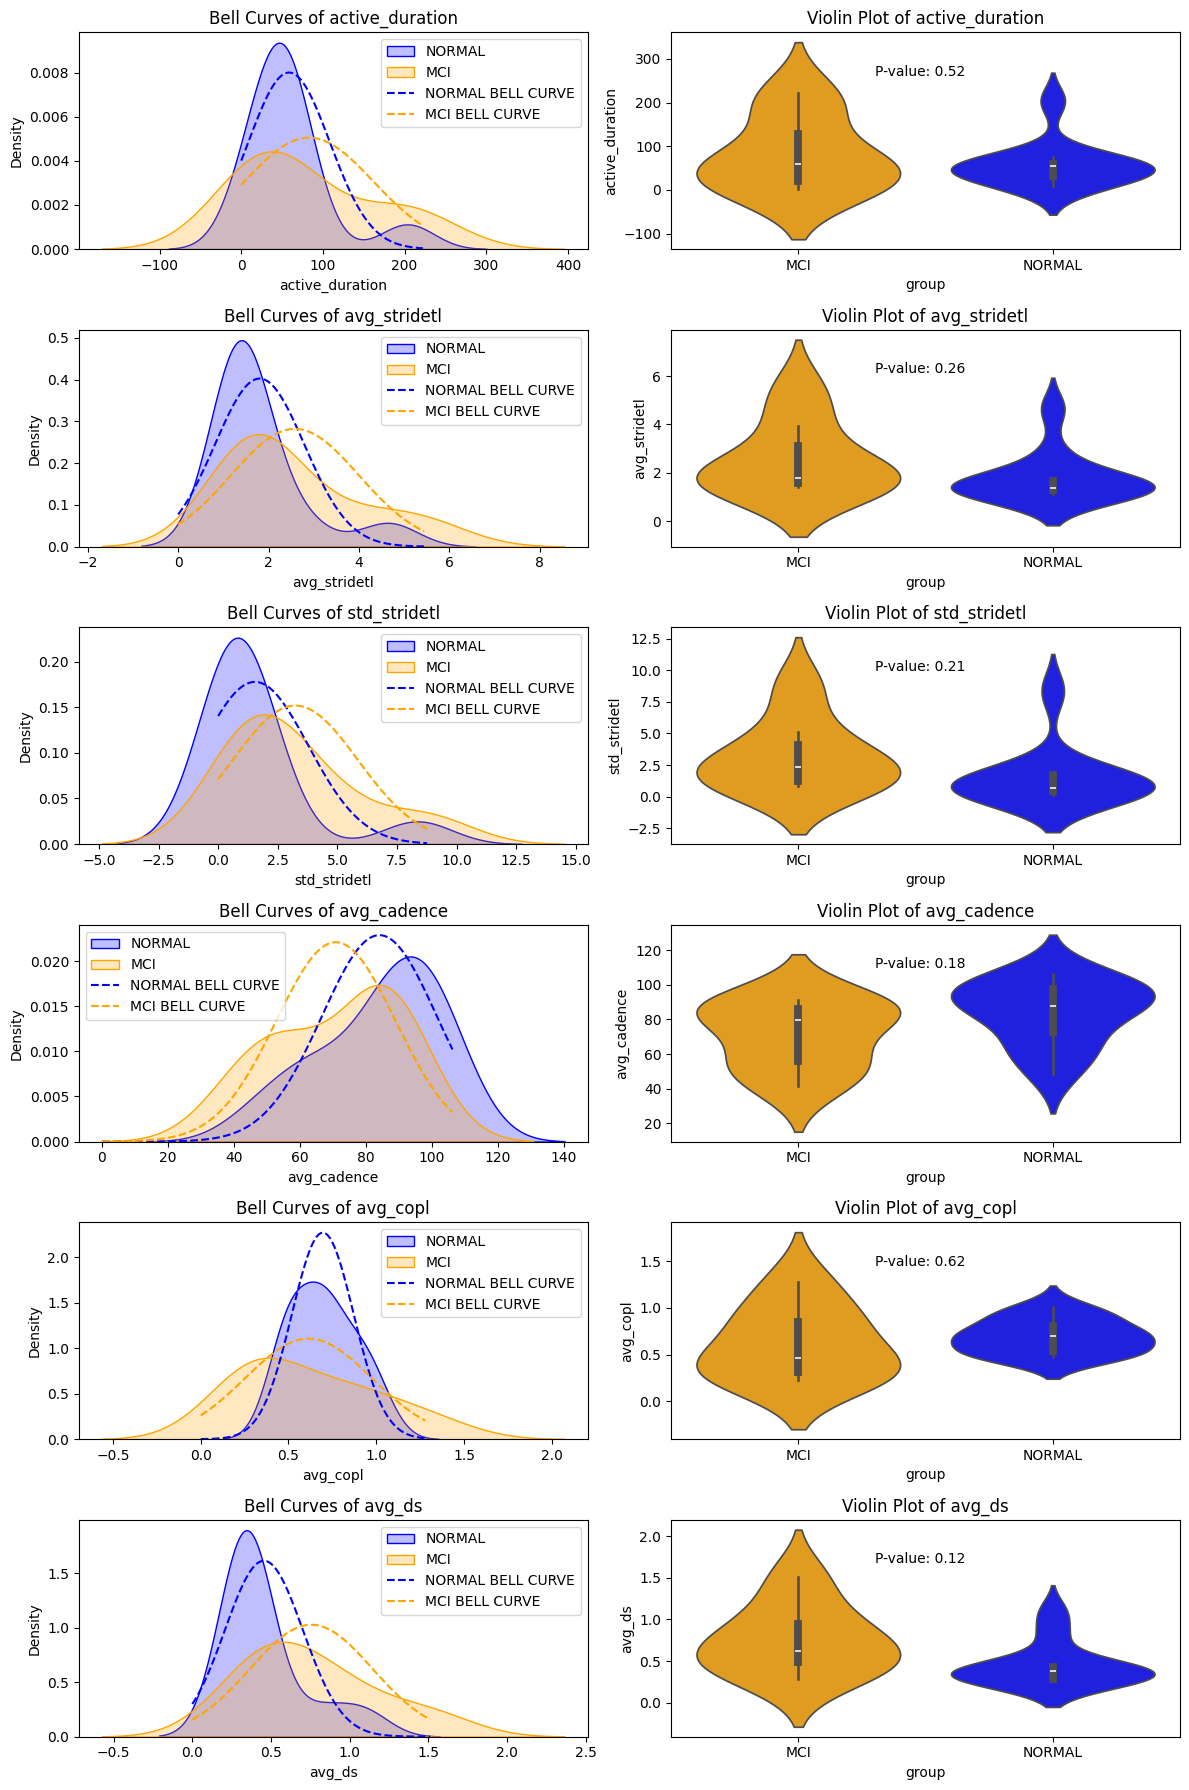

In [62]:
# plot only total activity, stride(gait) time, stride(gait) variability, cadence, and COP
fig, axs = plt.subplots(6, 2, figsize=(12, 18))

aggnl = agg_df[left_plt][agg_df['group'] == 'NORMAL']
aggml = agg_df[left_plt][agg_df['group'] == 'MCI']

for i, col in enumerate(left_plt[1:]):

    normal_data = aggnl[[col]]
    mci_data = aggml[[col]]

    sns.kdeplot(data=normal_data, label='NORMAL', x=col, color='blue', fill=True, ax=axs[i, 0])
    sns.kdeplot(data=mci_data, label='MCI', x=col, color='orange', fill=True, ax=axs[i, 0])

    mean_normal, std_normal = np.mean(normal_data[col]), np.std(normal_data[col])
    mean_mci, std_mci = np.mean(mci_data[col]), np.std(mci_data[col])

    x_min = 0
    x_max = max(max(normal_data[col]), max(mci_data[col]))
    x = np.linspace(x_min, x_max, 100)

    axs[i,0].plot(x, norm.pdf(x, mean_normal, std_normal), color='blue', linestyle='--', label='NORMAL BELL CURVE')
    axs[i,0].plot(x, norm.pdf(x, mean_mci, std_mci), color='orange', linestyle='--', label='MCI BELL CURVE')
    axs[i,0].legend()
    axs[i,0].set_title(f'Bell Curves of {col}')
    axs[i,0].set_xlabel(col)
    axs[i,0].set_ylabel('Density')
    # axs[i,0].tight_layout()

    t_stat, p_val = ttest_ind(normal_data, mci_data, equal_var=False, nan_policy='omit')

    sns.violinplot(data=agg_df[['group', col]], ax=axs[i,1], palette=['orange', 'blue'], x='group', y=col, hue='group')
    axs[i,1].set_title(f'Violin Plot of {col}')
    axs[i,1].set_ylabel(col)

    axs[i, 1].text(0.4, 0.8, f'P-value: {p_val[0]:.2f}', transform=axs[i, 1].transAxes)
    # axs[i,1].tight_layout()

plt.tight_layout()
plt.show()

In [75]:
aggopr = agg_df[right_parameters]

aggopr = ttest(aggopr)

aggopr.drop(columns=['T-stat'], index='group', inplace=True)
# aggopr

In [76]:
aggopr = infer(agg_df, right_parameters, aggopr)
aggopr = aggopr[['Mean_Healthy', 'Mean_MCI', 'Median_Healthy', 'Median_MCI', 'Std_Healthy', 'Std_MCI', 'Range_Healthy', 'Range_MCI', 'P-val', 'Significant']]
aggopr.index = ['Total Activity', 'Step Time', 'Swing Time', 'Gait Time', 'Cadence', 'Gait Variability', 'COP Speed', 'Double Support']
aggopr

,Mean_Healthy,Mean_MCI,Median_Healthy,Median_MCI,Std_Healthy,Std_MCI,Range_Healthy,Range_MCI,P-val,Significant
Total Activity,58.58,82.90,53.65,59.14,49.84,78.98,"(8.19, 203.56)","(2.87, 222.37)",0.52,False
Step Time,0.69,1.71,0.71,0.61,0.12,2.44,"(0.54, 0.99)","(0.55, 7.65)",0.35,False
Swing Time,0.86,1.53,0.67,0.64,0.59,2.07,"(0.53, 2.68)","(0.54, 6.57)",0.47,False
Gait Time,1.34,3.18,1.35,1.13,0.25,4.48,"(1.04, 1.97)","(1.05, 14.11)",0.35,False
Cadence,84.13,70.93,87.67,79.74,17.45,18.06,"(48.35, 106.29)","(41.55, 91.19)",0.18,False
Gait Variability,0.74,2.78,0.60,0.37,0.79,5.25,"(0.07, 3.0)","(0.09, 15.51)",0.38,False
COP Speed,0.86,0.62,0.82,0.60,0.35,0.33,"(0.46, 1.7)","(0.11, 1.05)",0.18,False
Double Support,0.45,0.76,0.38,0.62,0.25,0.39,"(0.27, 1.09)","(0.28, 1.51)",0.12,False


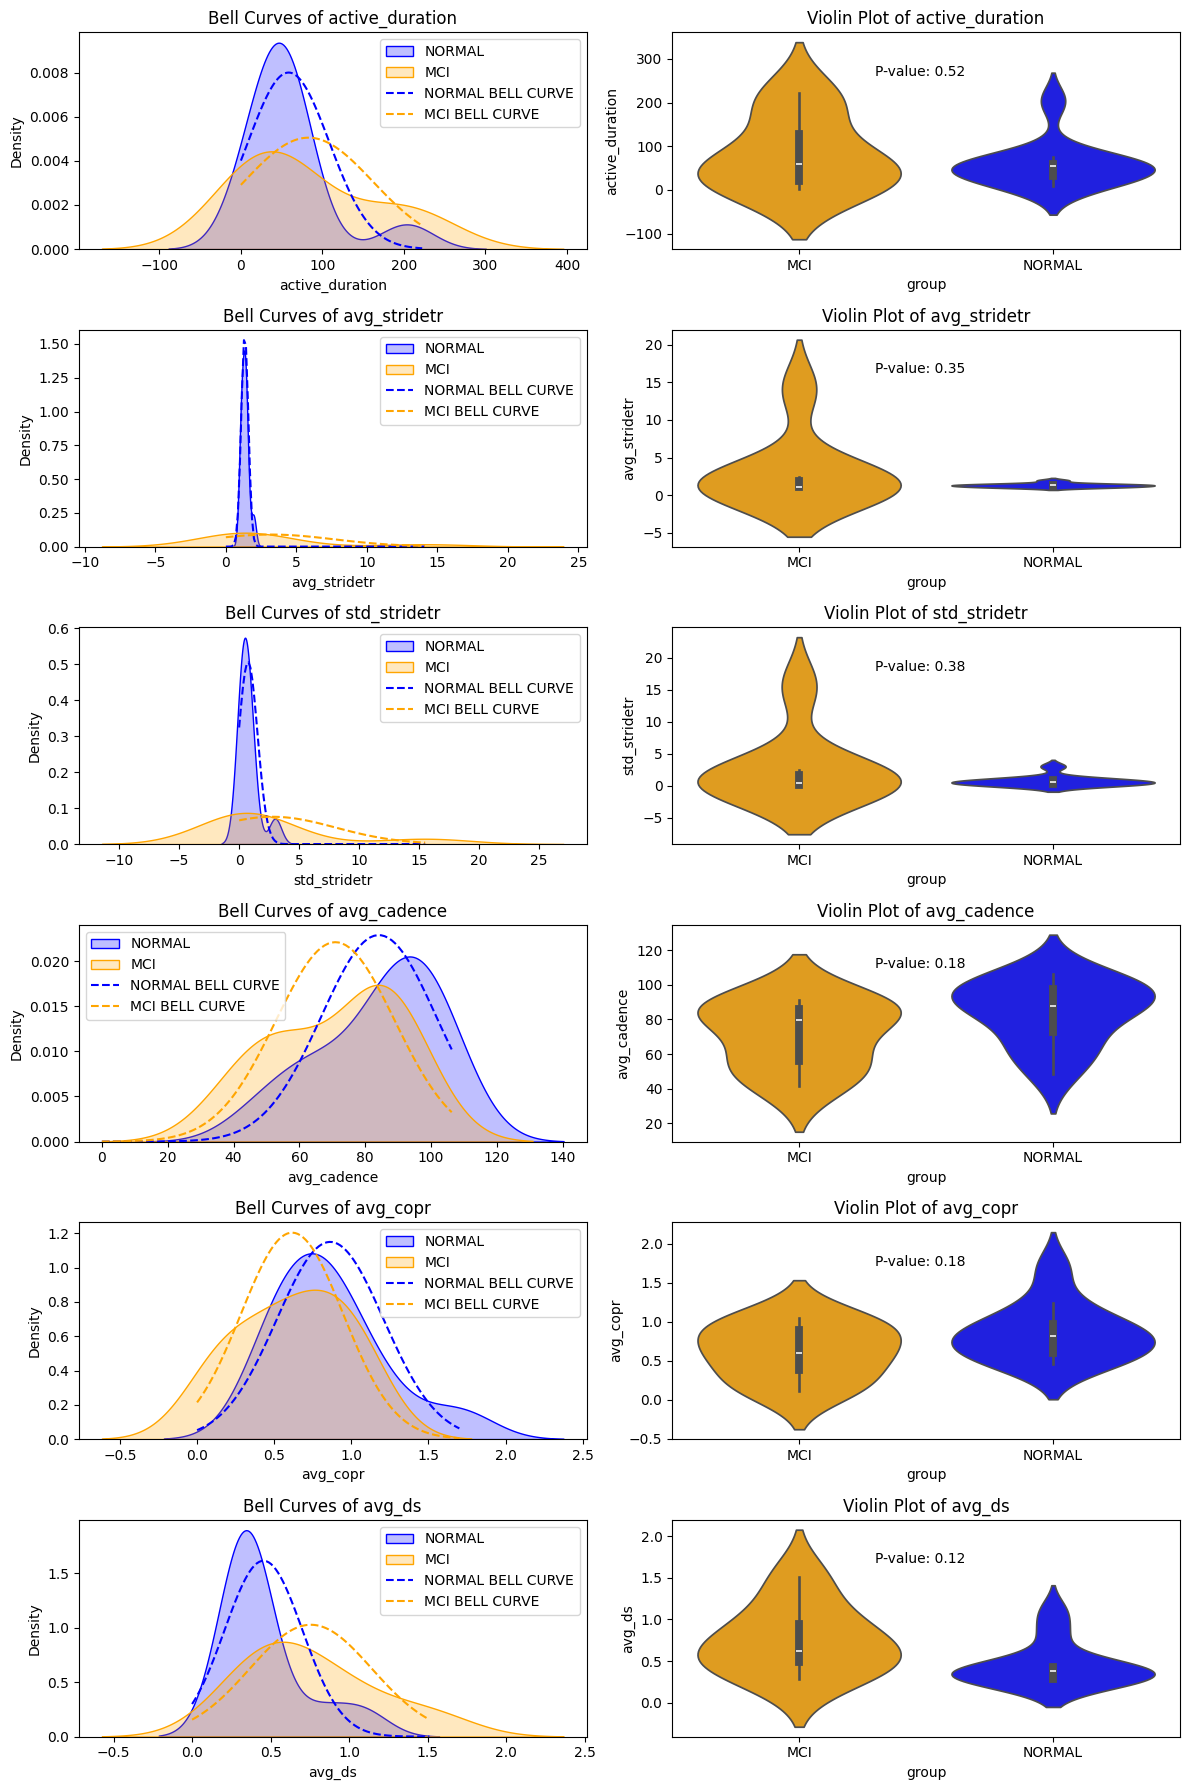

In [52]:
# plot only total activity, stride(gait) time, stride(gait) variability, cadence, and COP
fig, axs = plt.subplots(6, 2, figsize=(12, 18))

aggnl = agg_df[right_plt][agg_df['group'] == 'NORMAL']
aggml = agg_df[right_plt][agg_df['group'] == 'MCI']

for i, col in enumerate(right_plt[1:]):

    normal_data = aggnl[[col]]
    mci_data = aggml[[col]]

    sns.kdeplot(data=normal_data, label='NORMAL', x=col, color='blue', fill=True, ax=axs[i, 0])
    sns.kdeplot(data=mci_data, label='MCI', x=col, color='orange', fill=True, ax=axs[i, 0])

    mean_normal, std_normal = np.mean(normal_data[col]), np.std(normal_data[col])
    mean_mci, std_mci = np.mean(mci_data[col]), np.std(mci_data[col])

    x_min = 0
    x_max = max(max(normal_data[col]), max(mci_data[col]))
    x = np.linspace(x_min, x_max, 100)

    axs[i,0].plot(x, norm.pdf(x, mean_normal, std_normal), color='blue', linestyle='--', label='NORMAL BELL CURVE')
    axs[i,0].plot(x, norm.pdf(x, mean_mci, std_mci), color='orange', linestyle='--', label='MCI BELL CURVE')
    axs[i,0].legend()
    axs[i,0].set_title(f'Bell Curves of {col}')
    axs[i,0].set_xlabel(col)
    axs[i,0].set_ylabel('Density')
    # axs[i,0].tight_layout()

    t_stat, p_val = ttest_ind(normal_data, mci_data, equal_var=False, nan_policy='omit')

    sns.violinplot(data=agg_df[['group', col]], ax=axs[i,1], palette=['orange', 'blue'], x='group', y=col, hue='group')
    axs[i,1].set_title(f'Violin Plot of {col}')
    axs[i,1].set_ylabel(col)

    axs[i, 1].text(0.4, 0.8, f'P-value: {p_val[0]:.2f}', transform=axs[i, 1].transAxes)
    # axs[i,1].tight_layout()

plt.tight_layout()
plt.show()

#### **All Sessions**

In [33]:
f_df = fd.groupby(['group'])[['date']].min()
f_df.rename(columns={'date': 'start_date'}, inplace=True)
f_df['end_date'] = fd.groupby(['group'])['date'].max()

# f_df['total_sessions'] = fd.groupby(['group']).count()['session_id']
# f_df['active_sessions'] = fd[fd['speed'] > 0].groupby(['group']).count()['session_id']
# f_df['pct_active_sessions'] = np.round(f_df['active_sessions'] / f_df['total_sessions'] * 100, 2)

f_df['avg_speed'] = np.round(fd[fd['speed'] > 0].groupby(['group'])['speed'].mean(), 2)
f_df['std_speed'] = np.round(fd[fd['speed'] > 0].groupby(['group'])['speed'].std(), 2)

f_df['total_duration'] = np.round(fd.groupby(['group'])['full_duration'].sum() / 3600, 2)
f_df['active_duration'] = np.round(fd[fd['speed'] > 0].groupby(['group'])['full_duration'].sum() / 3600, 2)
f_df['pct_active_duration'] = np.round(f_df['active_duration'] / f_df['total_duration'] * 100, 2)

f_df['pct_sitting'] = np.round(fd.groupby(['group'])['sit_duration'].sum() / 3600 / f_df['total_duration'] * 100, 2)
f_df['pct_standing'] = np.round(fd.groupby(['group'])['stand_duration'].sum() / 3600 / f_df['total_duration'] * 100, 2)
f_df['pct_walking'] = np.round(fd.groupby(['group'])['walk_duration'].sum() / 3600 / f_df['total_duration'] * 100, 2)
f_df['pct_running'] = np.round(fd.groupby(['group'])['run_duration'].sum() / 3600 / f_df['total_duration'] * 100, 2)

f_df['avg_steptl'] = np.round(fd.groupby(['group'])['step_time_left'].mean(), 2)
f_df['std_steptl'] = np.round(fd.groupby(['group'])['step_time_left'].std(), 2)
f_df['avg_steptr'] = np.round(fd.groupby(['group'])['step_time_right'].mean(), 2)
f_df['std_steptr'] = np.round(fd.groupby(['group'])['step_time_right'].std(), 2)

f_df['avg_swingtl'] = np.round(fd.groupby(['group'])['swing_time_left'].mean(), 2)
f_df['std_swingtl'] = np.round(fd.groupby(['group'])['swing_time_left'].std(), 2)
f_df['avg_swingtr'] = np.round(fd.groupby(['group'])['swing_time_right'].mean(), 2)
f_df['std_swingtr'] = np.round(fd.groupby(['group'])['swing_time_right'].std(), 2)

f_df['avg_stridetl'] = np.round(fd.groupby(['group'])['stride_time_left'].mean(), 2)
f_df['std_stridetl'] = np.round(fd.groupby(['group'])['stride_time_left'].std(), 2)
f_df['avg_stridetr'] = np.round(fd.groupby(['group'])['stride_time_right'].mean(), 2)
f_df['std_stridetr'] = np.round(fd.groupby(['group'])['stride_time_right'].std(), 2)

f_df['avg_cadence'] = np.round(fd.groupby(['group'])['cadence'].mean(), 2)
f_df['std_cadence'] = np.round(fd.groupby(['group'])['cadence'].std(), 2)

f_df['avg_copl'] = np.round(fd.groupby(['group'])['cop_speed_left'].mean(), 2)
f_df['std_copl'] = np.round(fd.groupby(['group'])['cop_speed_left'].std(), 2)
f_df['avg_copr'] = np.round(fd.groupby(['group'])['cop_speed_right'].mean(), 2)
f_df['std_copr'] = np.round(fd.groupby(['group'])['cop_speed_right'].std(), 2)

f_df['avg_ssl'] = np.round(fd.groupby(['group'])['single_support_left'].mean(), 2)
f_df['std_ssl'] = np.round(fd.groupby(['group'])['single_support_left'].std(), 2)
f_df['avg_ssr'] = np.round(fd.groupby(['group'])['single_support_right'].mean(), 2)
f_df['std_ssr'] = np.round(fd.groupby(['group'])['single_support_right'].std(), 2)

f_df['avg_ds'] = np.round(fd.groupby(['group'])['double_support'].mean(), 2)
f_df['std_ds'] = np.round(fd.groupby(['group'])['double_support'].std(), 2)


f_df

,start_date,end_date,avg_speed,std_speed,total_duration,active_duration,pct_active_duration,pct_sitting,pct_standing,pct_walking,...,avg_copl,std_copl,avg_copr,std_copr,avg_ssl,std_ssl,avg_ssr,std_ssr,avg_ds,std_ds
group,,,,,,,,,,,,,,,,,,,,,
MCI,1/3/24,9/3/24,0.94,0.08,580.31,580.31,100.0,37.57,46.88,8.65,...,0.42,0.46,0.37,0.44,0.97,2.46,1.79,3.88,0.82,2.46
NORMAL,1/2/24,9/3/24,0.95,0.07,644.42,644.42,100.0,37.35,37.77,12.25,...,0.72,0.57,0.85,0.69,0.54,2.04,0.36,0.26,0.42,1.64


In [35]:
left_parameters = ['group', 'full_duration', 'step_time_left', 'swing_time_left', 'stride_time_left', 'cadence', 'cop_speed_left', 'double_support']
left_plt = ['group', 'full_duration', 'stride_time_left', 'cadence', 'cop_speed_left', 'double_support']

right_parameters = ['group', 'full_duration', 'step_time_right', 'swing_time_right', 'stride_time_right', 'cadence', 'cop_speed_right', 'double_support']
right_plt = ['group', 'full_duration', 'stride_time_right', 'cadence', 'cop_speed_right', 'double_support']


In [40]:
fopl = fd[left_parameters]

fopl = ttest(fopl)

fopl.drop(columns=['t_stat'], index='group', inplace=True)
# fopl

In [41]:
fopl = infer(fd, left_parameters, fopl)
fopl = fopl[['mean_healthy', 'mean_mci', 'median_healthy', 'median_mci', 'std_healthy', 'std_mci', 'range_healthy', 'range_mci', 'p_val', 'significant']]
fopl

,mean_healthy,mean_mci,median_healthy,median_mci,std_healthy,std_mci,range_healthy,range_mci,p_val,significant
full_duration,4557.761984,6849.612459,3599.950000,3598.950000,9407.954353,16635.452060,"(21.95, 86399.95)","(36.85, 86399.95)",0.028298,True
step_time_left,0.983532,1.803569,0.606236,0.766477,3.470723,4.864206,"(0.0, 72.35000000000001)","(0.0, 66.0)",0.010363,True
swing_time_left,0.823694,1.742450,0.588608,0.700798,1.419106,4.479751,"(0.0, 25.883333333333336)","(0.0, 54.400000000000006)",0.000581,True
stride_time_left,1.614430,2.778174,1.162509,1.402087,2.468637,4.022586,"(0.0, 38.975)","(0.0, 45.95)",0.000007,True
cadence,88.882074,64.994823,99.657143,67.239945,31.311902,41.298927,"(0.0, 131.53846153846155)","(0.0, 128.3085013146363)",0.0,True
cop_speed_left,0.720163,0.416722,0.600372,0.258529,0.566171,0.457456,"(0.0, 3.8922523244768574)","(0.0, 2.094339034395697)",0.0,True
double_support,0.423750,0.822495,0.287776,0.345614,1.634231,2.455794,"(0.0, 36.3)","(0.0, 33.050000000000004)",0.012168,True


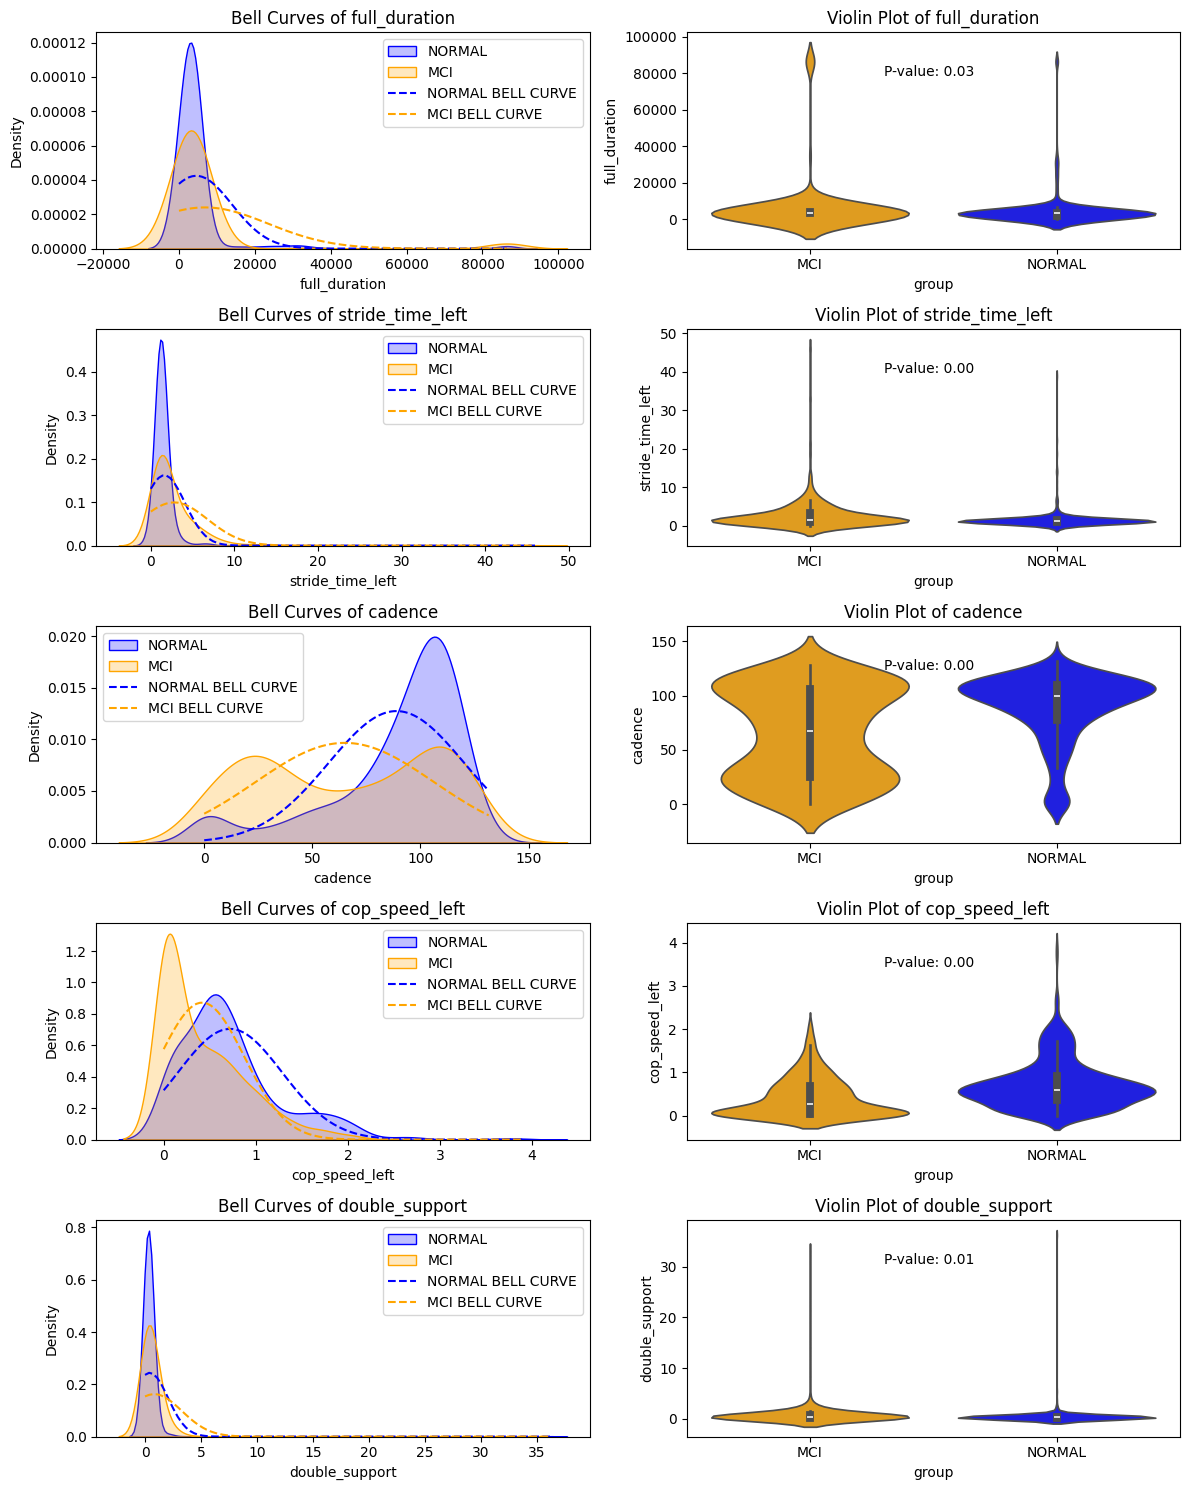

In [42]:
# plot only total activity, stride(gait) time, stride(gait) variability, cadence, and COP
fig, axs = plt.subplots(5, 2, figsize=(12, 15))

fnl = fd[left_plt][fd['group'] == 'NORMAL']
fml = fd[left_plt][fd['group'] == 'MCI']

for i, col in enumerate(left_plt[1:]):

    normal_data = fnl[[col]]
    mci_data = fml[[col]]

    sns.kdeplot(data=normal_data, label='NORMAL', x=col, color='blue', fill=True, ax=axs[i, 0])
    sns.kdeplot(data=mci_data, label='MCI', x=col, color='orange', fill=True, ax=axs[i, 0])

    mean_normal, std_normal = np.mean(normal_data[col]), np.std(normal_data[col])
    mean_mci, std_mci = np.mean(mci_data[col]), np.std(mci_data[col])

    x_min = 0
    x_max = max(max(normal_data[col]), max(mci_data[col]))
    x = np.linspace(x_min, x_max, 100)

    axs[i,0].plot(x, norm.pdf(x, mean_normal, std_normal), color='blue', linestyle='--', label='NORMAL BELL CURVE')
    axs[i,0].plot(x, norm.pdf(x, mean_mci, std_mci), color='orange', linestyle='--', label='MCI BELL CURVE')
    axs[i,0].legend()
    axs[i,0].set_title(f'Bell Curves of {col}')
    axs[i,0].set_xlabel(col)
    axs[i,0].set_ylabel('Density')
    # axs[i,0].tight_layout()

    t_stat, p_val = ttest_ind(normal_data, mci_data, equal_var=False, nan_policy='omit')

    sns.violinplot(data=fd[['group', col]], ax=axs[i,1], palette=['orange', 'blue'], x='group', y=col, hue='group')
    axs[i,1].set_title(f'Violin Plot of {col}')
    axs[i,1].set_ylabel(col)

    axs[i, 1].text(0.4, 0.8, f'P-value: {p_val[0]:.2f}', transform=axs[i, 1].transAxes)
    # axs[i,1].tight_layout()

plt.tight_layout()
plt.show()

In [43]:
fopr = fd[right_parameters]

fopr = ttest(fopr)

fopr.drop(columns=['t_stat'], index='group', inplace=True)
# fopr

In [44]:
fopr = infer(fd, right_parameters, fopr)
fopr = fopr[['mean_healthy', 'mean_mci', 'median_healthy', 'median_mci', 'std_healthy', 'std_mci', 'range_healthy', 'range_mci', 'p_val', 'significant']]
fopr

,mean_healthy,mean_mci,median_healthy,median_mci,std_healthy,std_mci,range_healthy,range_mci,p_val,significant
full_duration,4557.761984,6849.612459,3599.950000,3598.950000,9407.954353,16635.452060,"(21.95, 86399.95)","(36.85, 86399.95)",0.028298,True
step_time_right,0.701439,3.450706,0.593419,0.739412,0.481166,6.760924,"(0.0, 8.819230769230769)","(0.0, 59.70000000000001)",0.0,True
swing_time_right,0.829312,2.983230,0.580449,0.728453,2.991081,4.903512,"(0.0, 67.10000000000001)","(0.0, 31.450000000000003)",0.0,True
stride_time_right,1.369211,6.379320,1.154026,1.444191,1.012989,11.314358,"(0.0, 17.867307692307694)","(0.0, 92.0)",0.0,True
cadence,88.882074,64.994823,99.657143,67.239945,31.311902,41.298927,"(0.0, 131.53846153846155)","(0.0, 128.3085013146363)",0.0,True
cop_speed_right,0.849590,0.367985,0.739870,0.195174,0.686338,0.442572,"(0.0, 3.5576090492299155)","(0.0, 2.373340268891901)",0.0,True
double_support,0.423750,0.822495,0.287776,0.345614,1.634231,2.455794,"(0.0, 36.3)","(0.0, 33.050000000000004)",0.012168,True


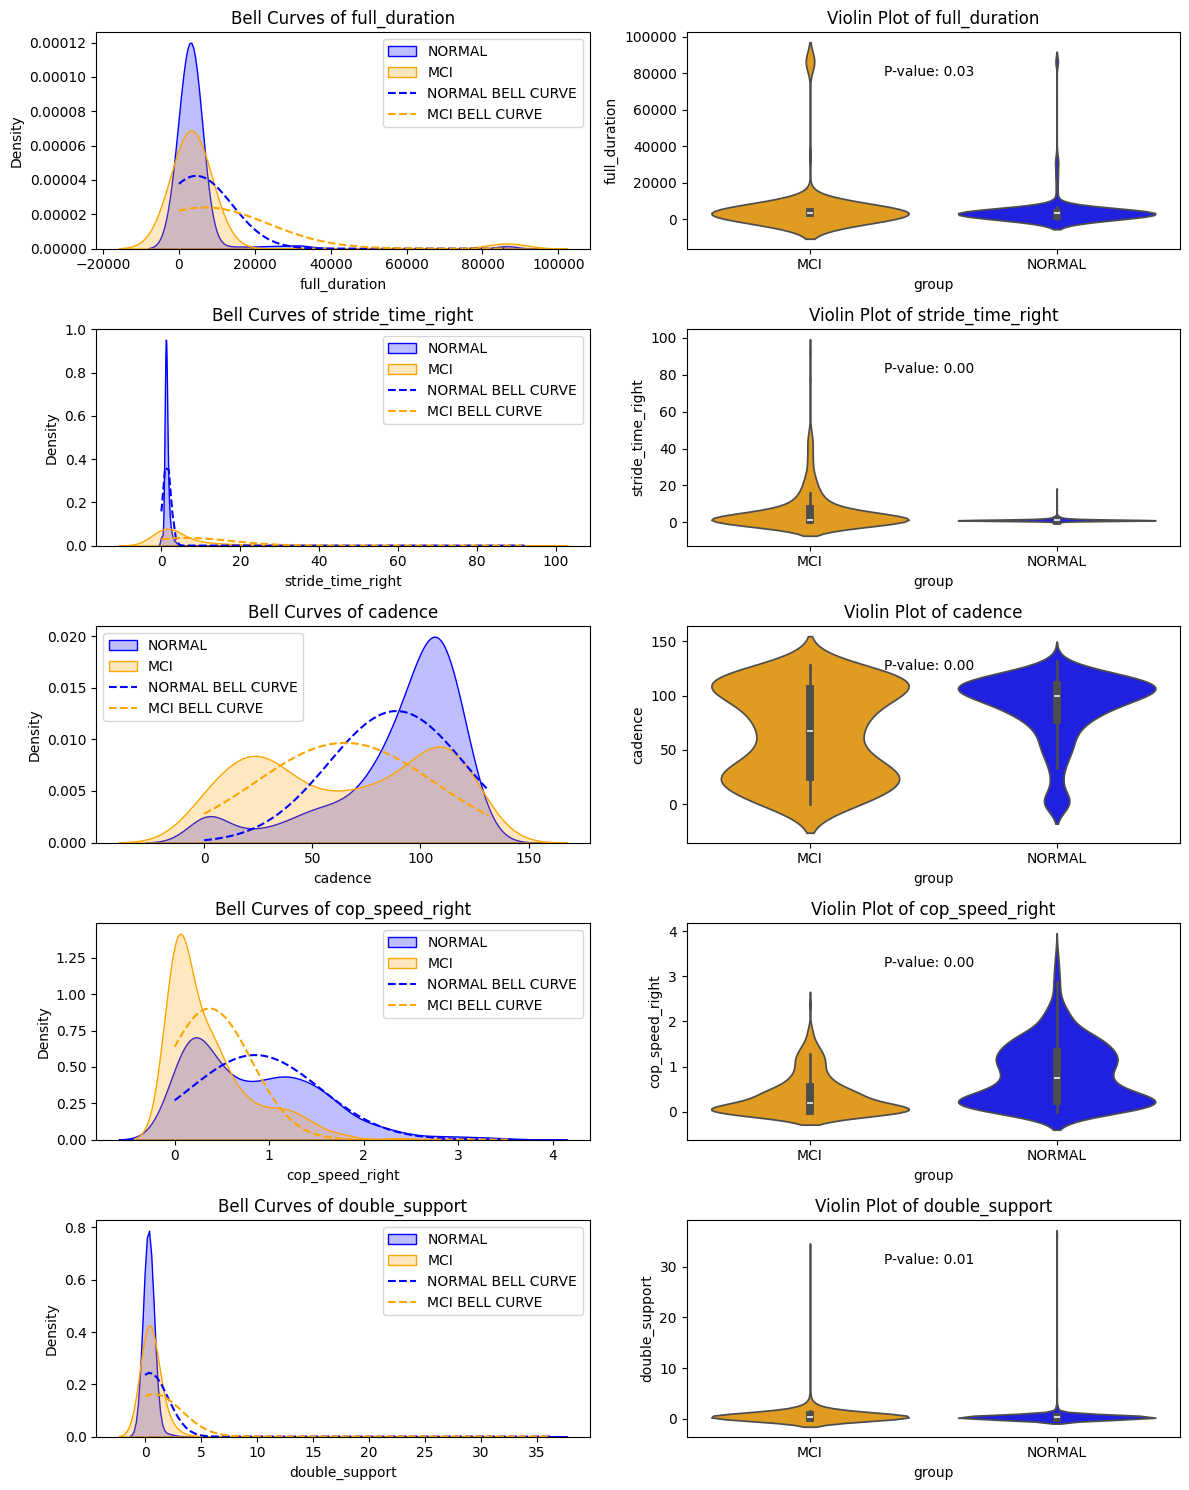

In [45]:
# plot only total activity, stride(gait) time, stride(gait) variability, cadence, and COP
fig, axs = plt.subplots(5, 2, figsize=(12, 15))

fnl = fd[right_plt][fd['group'] == 'NORMAL']
fml = fd[right_plt][fd['group'] == 'MCI']

for i, col in enumerate(right_plt[1:]):

    normal_data = fnl[[col]]
    mci_data = fml[[col]]

    sns.kdeplot(data=normal_data, label='NORMAL', x=col, color='blue', fill=True, ax=axs[i, 0])
    sns.kdeplot(data=mci_data, label='MCI', x=col, color='orange', fill=True, ax=axs[i, 0])

    mean_normal, std_normal = np.mean(normal_data[col]), np.std(normal_data[col])
    mean_mci, std_mci = np.mean(mci_data[col]), np.std(mci_data[col])

    x_min = 0
    x_max = max(max(normal_data[col]), max(mci_data[col]))
    x = np.linspace(x_min, x_max, 100)

    axs[i,0].plot(x, norm.pdf(x, mean_normal, std_normal), color='blue', linestyle='--', label='NORMAL BELL CURVE')
    axs[i,0].plot(x, norm.pdf(x, mean_mci, std_mci), color='orange', linestyle='--', label='MCI BELL CURVE')
    axs[i,0].legend()
    axs[i,0].set_title(f'Bell Curves of {col}')
    axs[i,0].set_xlabel(col)
    axs[i,0].set_ylabel('Density')
    # axs[i,0].tight_layout()

    t_stat, p_val = ttest_ind(normal_data, mci_data, equal_var=False, nan_policy='omit')

    sns.violinplot(data=fd[['group', col]], ax=axs[i,1], palette=['orange', 'blue'], x='group', y=col, hue='group')
    axs[i,1].set_title(f'Violin Plot of {col}')
    axs[i,1].set_ylabel(col)

    axs[i, 1].text(0.4, 0.8, f'P-value: {p_val[0]:.2f}', transform=axs[i, 1].transAxes)
    # axs[i,1].tight_layout()

plt.tight_layout()
plt.show()